In [1]:
import numpy             as np
import matplotlib.pyplot as plt

# CBF
from data      import make_rectangle, insert_shape, plot_data
from agent     import Agent
from tst_optim import cvx_train_cbf, get_h
from utils     import plot_cbf
from controls  import hjb_controls

# HJB
from   IPython.display      import HTML
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj

%load_ext autoreload
%autoreload 2

0.065


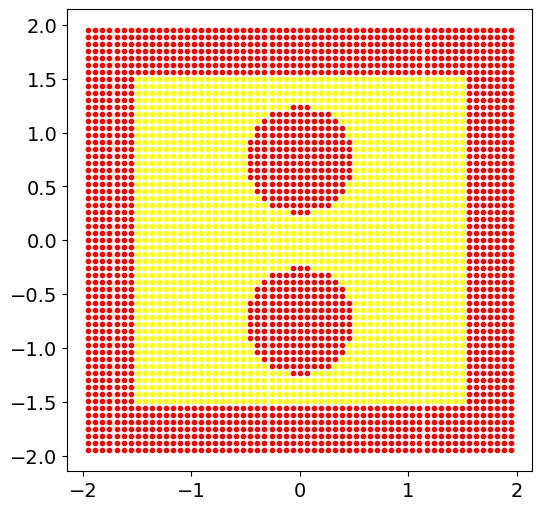

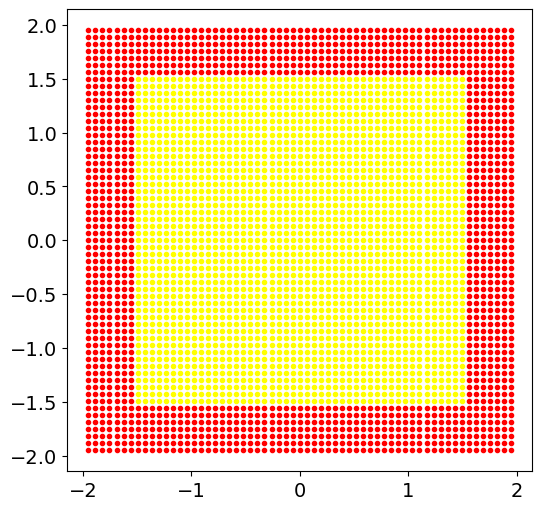

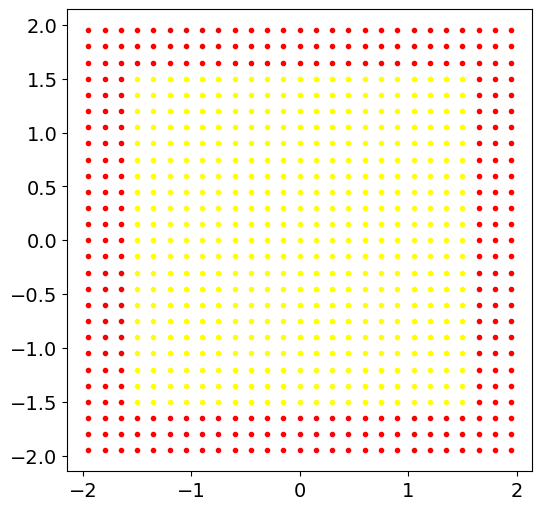

In [2]:
#########################
### Data Construction ###
#########################

# grid parameters
width         = 3
unsafe_margin = 0.3
density       = 250

# make grid and two circular obstacles, collect obstacle points
grid, params, obs_dict = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
obs_dict  = insert_shape(np.array([0,  0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obs_dict  = insert_shape(np.array([0, -0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])

# auxiliary grids 
c_grid, c_params, c_obs_dict = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/5, unsafe_margin=unsafe_margin, center=(0,0))

# HJB grid
lo, hi, n, s = params
print(s)
s=0.75
hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(3721, 2)


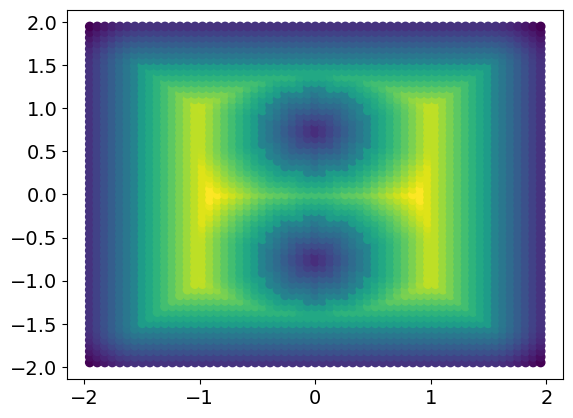

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j]), 3))] != 0:
            l[i, j] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j], axis=1))
        else:
            l[i, j] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j], axis=1))

print(grid.shape)
plt.scatter(grid[:,0], grid[:,1], c=l.reshape(-1, 1))
plt.show()

In [4]:
#############################
### Configure HJB Solver ###
#############################
utype           ="ball"
umax            = 1
values          = jnp.array(l)
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
###################################
### Solve PDE for final surface ###
###################################

dynamics      = hj.systems.Planar(control_type=utype, umax=umax)
time          = 0.
target_time   =-10
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

ball constraints with umax 1


100%|#################################| 10.0000/10.0 [00:00<00:00, 10.16sim_s/s]


<Figure size 640x480 with 0 Axes>

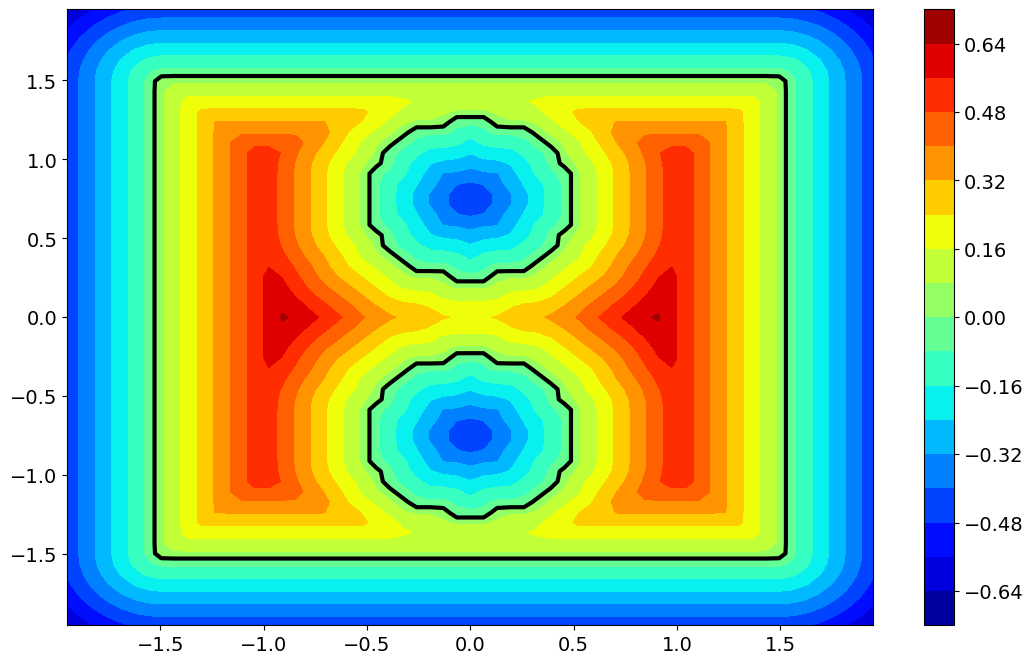

In [6]:
##########################
### Plot final surface ### 
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :].T, levels=16)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [7]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -30, 58)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|#################################| 30.0000/30.0 [00:03<00:00,  9.87sim_s/s]


In [8]:
#######################################################
### Visualize evolution of backwards reachable tube ###
#######################################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [9]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-0.5   # offset 
s     = 0.85  # csrbf zeroing
rx    = 1.5   # sample radius
nm    = 0.2   # nm * n_safe = number of neighbors to consider
p     = 0.5   # num neighber percentile under which boundary
rc    = 1     # radius around scan in which centers are chosen
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
solver = 'MOSEK'
sensor_radius = 1

# make agent
a = Agent(dynamics, np.array([0, 0]), grid, obs_dict, width         = width, 
                                                      sensor_radius = 1, 
                                                      bf            = bf, 
                                                      b             = b, 
                                                      s             = s,
                                                      umax          = umax,
                                                      utype         = utype,
                                                      solver        = solver)


# Test 
x = hjb_grid.states[2, 3]
hjb_controls(a, x, hjb_grid, all_values[-1], verbose=True)


umax: 1
utype: ball
cvx result: 4.1989484
dual norm result: 4.198948383331299


array([0.798122  , 0.60249587])

In [12]:
############################
### Scan for initial CBF ###
############################

scan_safe, scan_unsafe = a.scan()

samples  = a.sample(rx, grid=s_grid)
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples
    
n_safe = scan_safe.shape[0]
x_buffer, x_safe = a.make_buffer(scan_safe, int(nm * n_safe), p)

u_buffer = np.array([hjb_controls(a, x, hjb_grid, all_values[-1], verbose=False) for x in x_buffer])
u_safe   = np.array([hjb_controls(a, x, hjb_grid, all_values[-1], verbose=False) for x in x_safe  ])

C = []
for x in c_grid:
    if np.linalg.norm(x - a.pos) <= rc:
        C.append(x)
C = np.array(C)
a.centers.append(C)

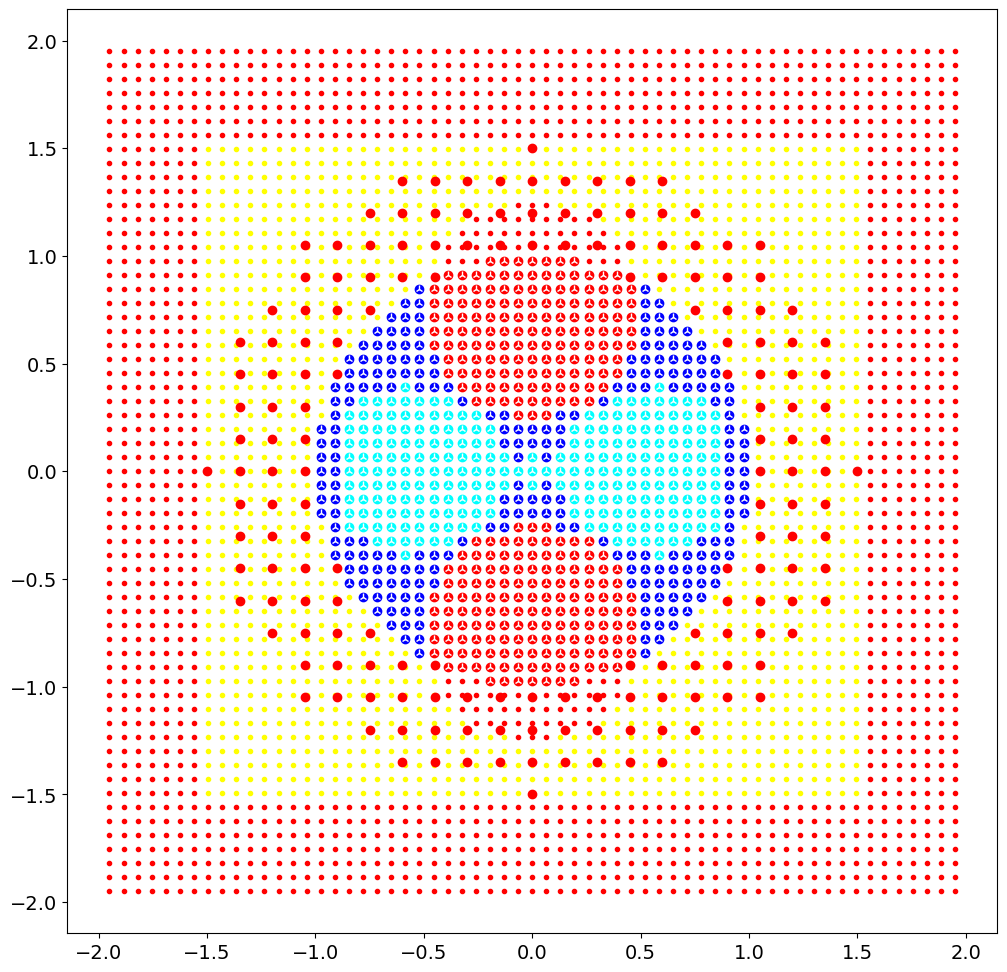

In [13]:
##############################
### Plot  Initial CBF Data ###
##############################

plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                           (x_buffer, "blue"  , 'o'), 
                           (x_unsafe, "red"   , 'o'),
                           (C       , "white" , '2')])

In [14]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

gamma_safe   = 0.3  
gamma_unsafe =-0.3
gamma_dyn    = 0.01
lam_dh       = 10
lam_sp       = 50

theta = cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)

a.thetas.append(theta)
a.rectify_c_and_theta()

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 05 07:14:33 AM: Your problem has 749 variables, 1156 constraints, and 0 parameters.
(CVXPY) Jul 05 07:14:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 05 07:14:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 05 07:14:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 05 07:14:33 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 05 07:14:33 AM: Compiling problem (target solver=MOSEK).

(749,)
(1, 749)


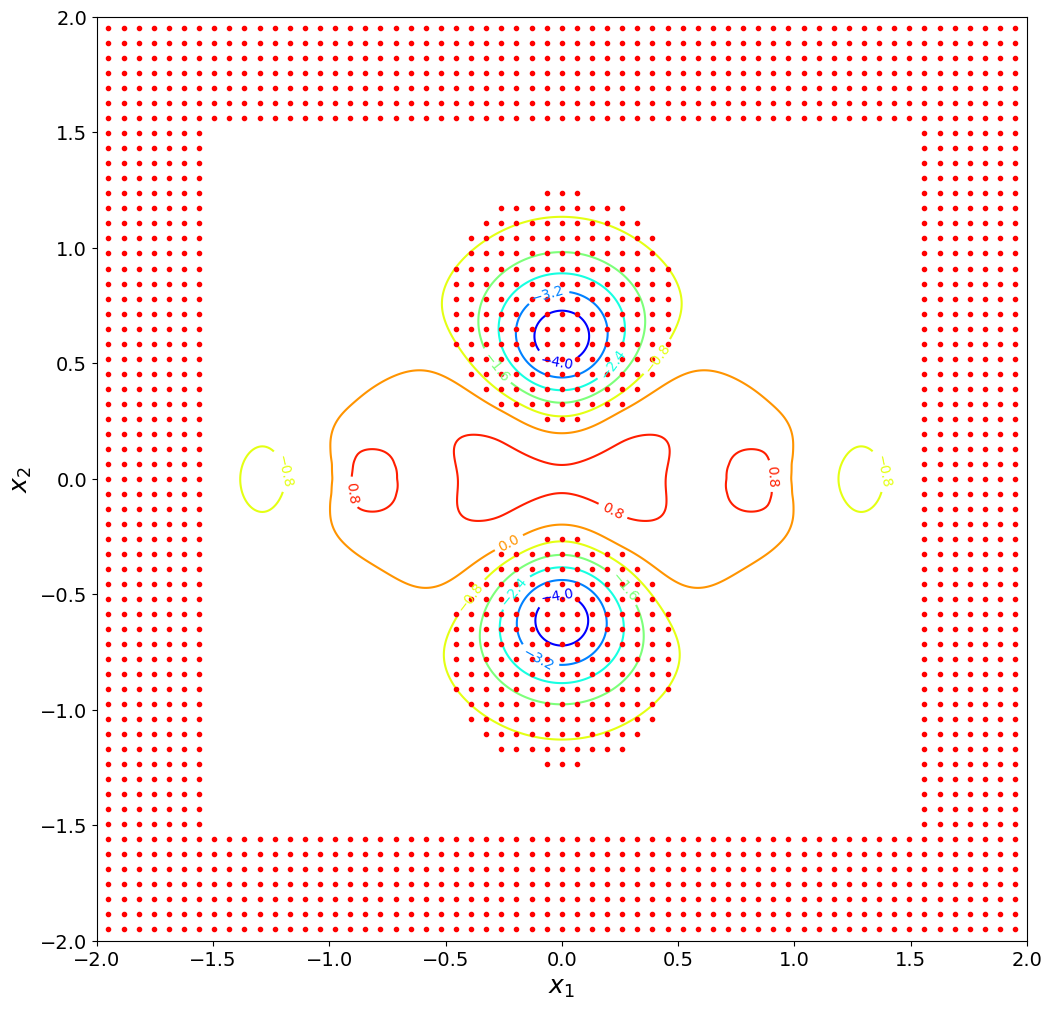

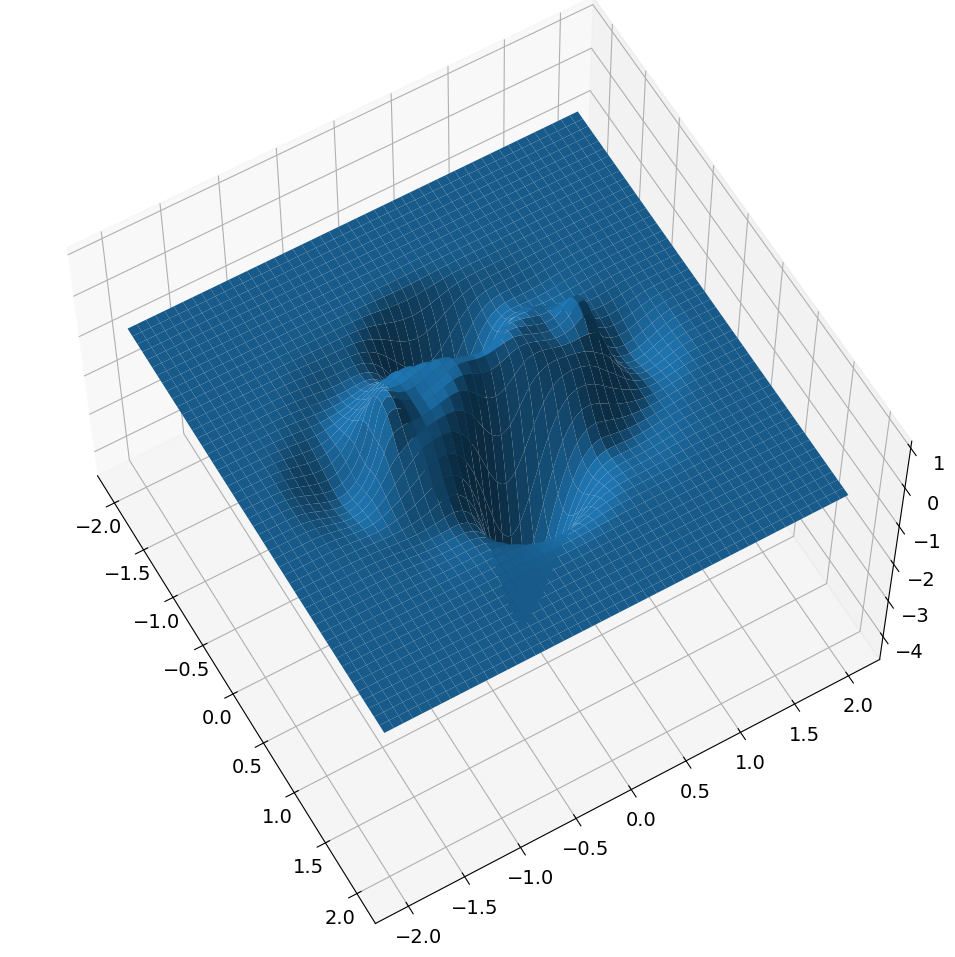

max h 1.053603455773847


1.053603455773847

In [15]:
print(a.thetas[0].shape)
print(np.array(a.thetas).shape)
plot_cbf(a, np.array(a.centers), np.array(a.thetas), obstacles=obstacles)

In [22]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.005
tol  = 0.2 # h-value at which to halt approac
dx   = 0.5 # if |x'-x|<dx, approach again
tend = 50  # Duration of boundary approach
T    = 3   # MPC horizon (default timestep is 0.05)
N    = 30  # number of CBFs to learn

target: [ 0.75554804 -1.10072718]
position is [0.47365863 1.23328986]
h is 0.9650582779899604
start time is 100
norm grad 1.5507868095825146
norm grad 2.1182963373292063
norm grad 2.711199004956553
norm grad 3.302106850130316
norm grad 3.875139547650836
norm grad 4.335796523622003
norm grad 4.697848719677633
norm grad 4.991374930592972
norm grad 5.2325183495388385
norm grad 5.424055153901212
norm grad 5.545028045842964
norm grad 5.615229515222812
norm grad 5.654783323539025
norm grad 5.667352137852327
norm grad 5.657427730255245
norm grad 5.639384664365856
norm grad 5.644080413366658
norm grad 5.696567726566267
norm grad 5.781554403205687
norm grad 5.869519997622843
norm grad 5.9471193780060725
norm grad 6.012910109607426
norm grad 6.068664265790332
norm grad 6.115712620310699
norm grad 6.153988960651991
norm grad 6.1821711782616475
norm grad 6.198623344996978
norm grad 6.202791371135034
norm grad 6.195836010817645
norm grad 6.180250770411423
norm grad 6.158737937683758
norm grad 6.133

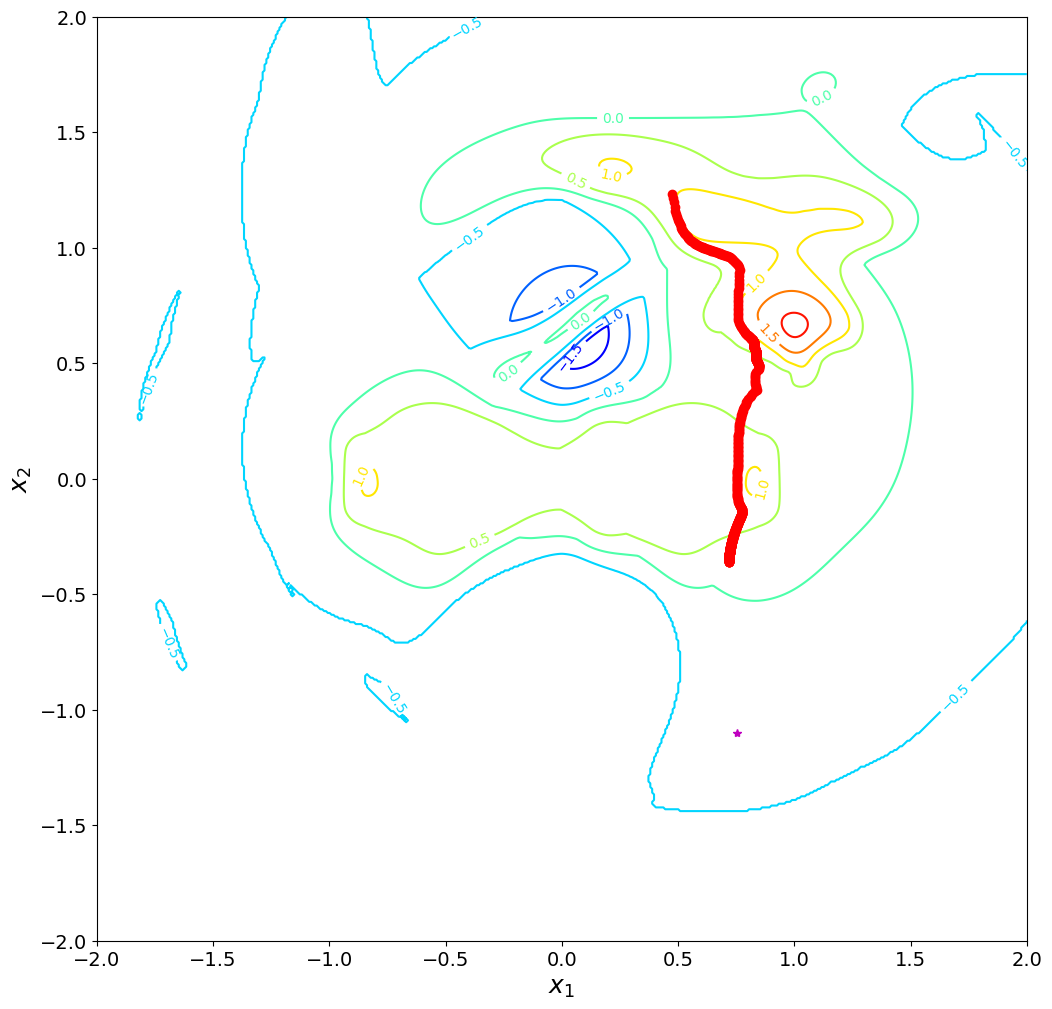

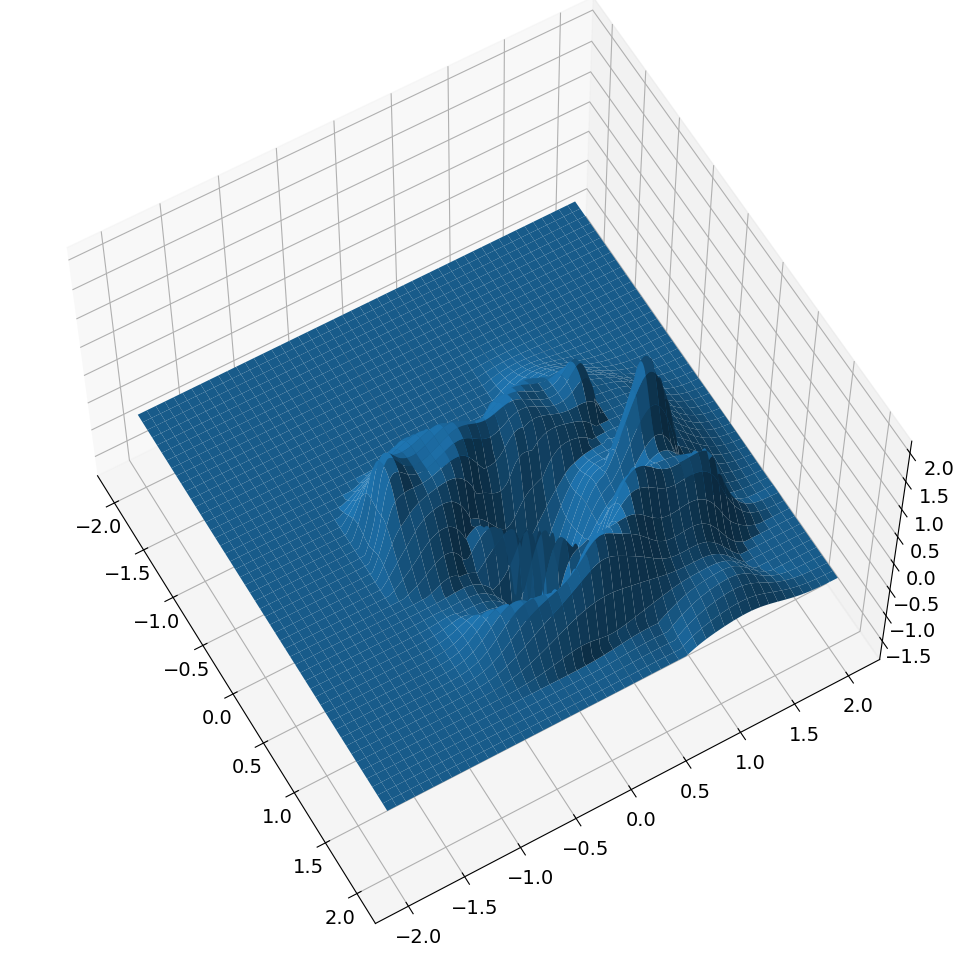

max h 2.124601838269041
new position is [ 0.71849275 -0.36014304]
h is now 0.19926922261854474
new time is 150
dx: 1.6121327955085103


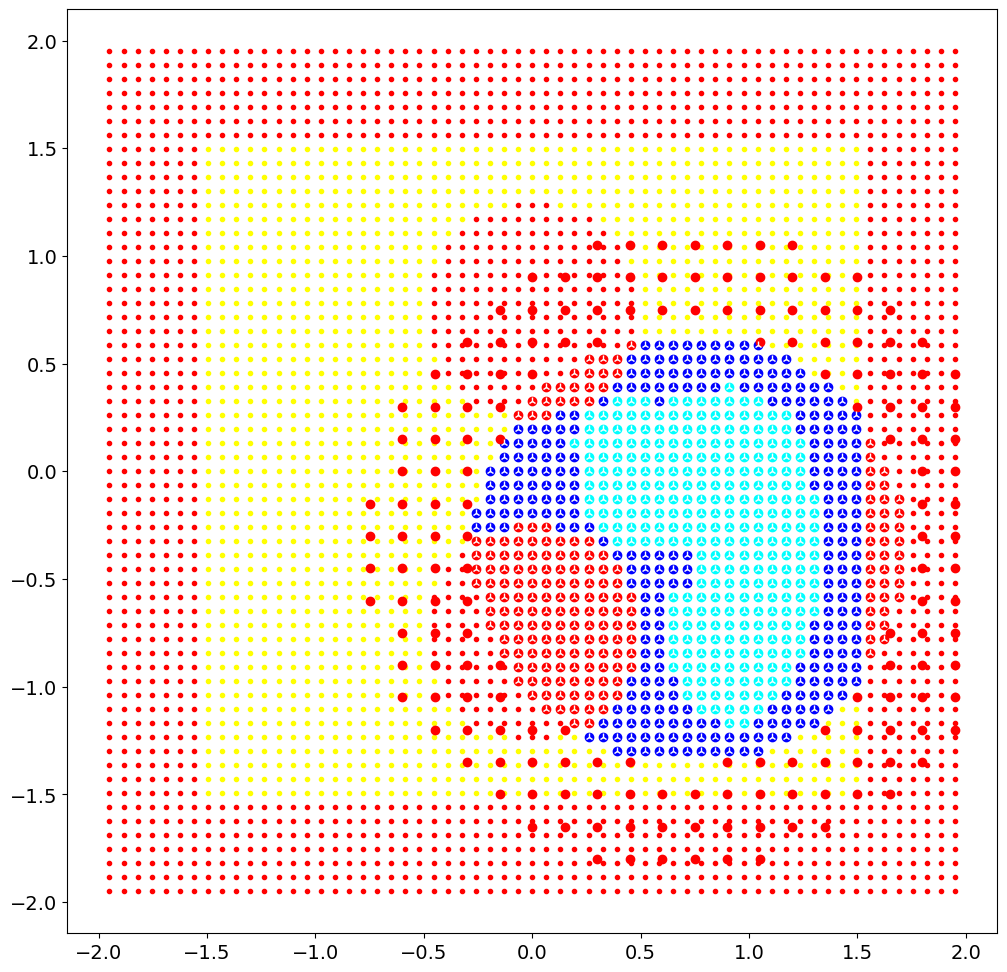

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 05 10:31:01 AM: Your problem has 745 variables, 1194 constraints, and 0 parameters.
(CVXPY) Jul 05 10:31:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 05 10:31:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 05 10:31:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 05 10:31:02 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 05 10:31:02 AM: Compiling problem (target solver=MOSEK).

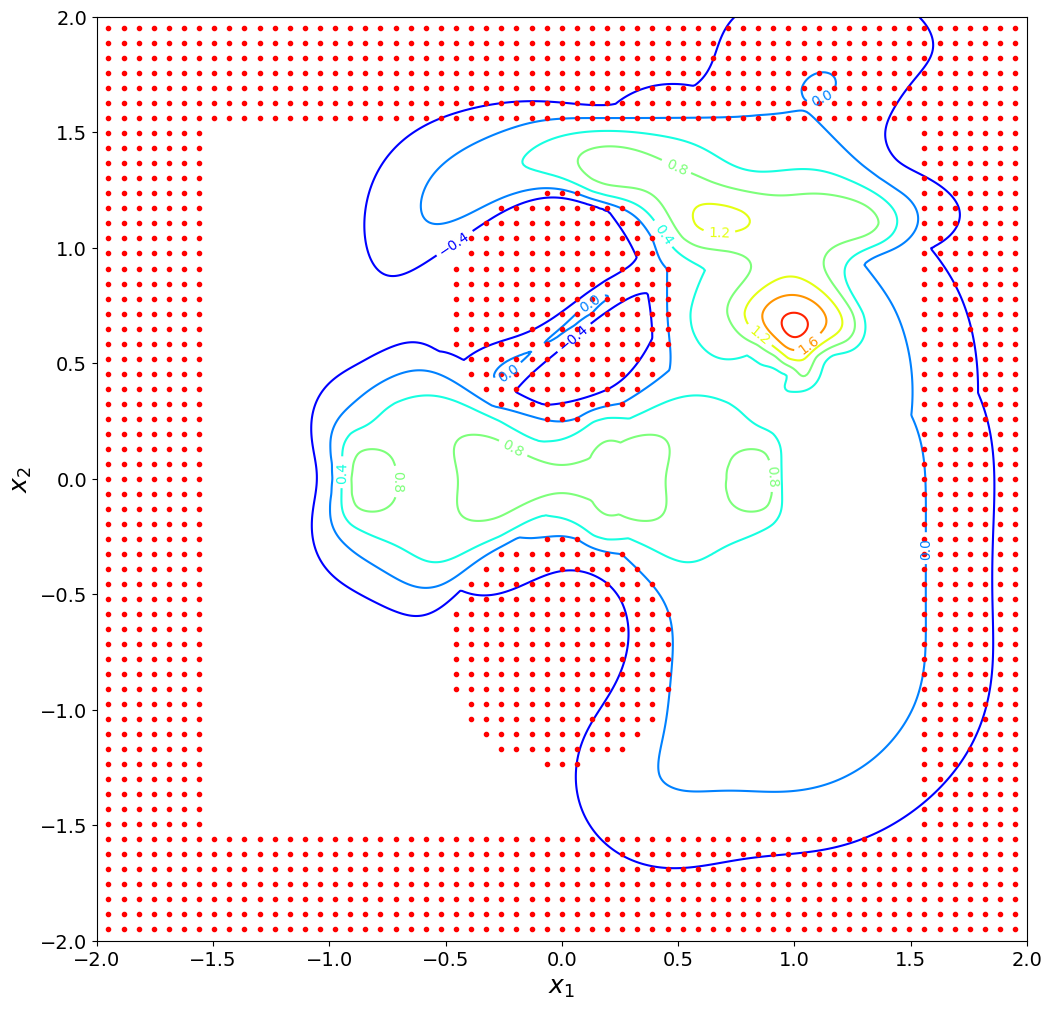

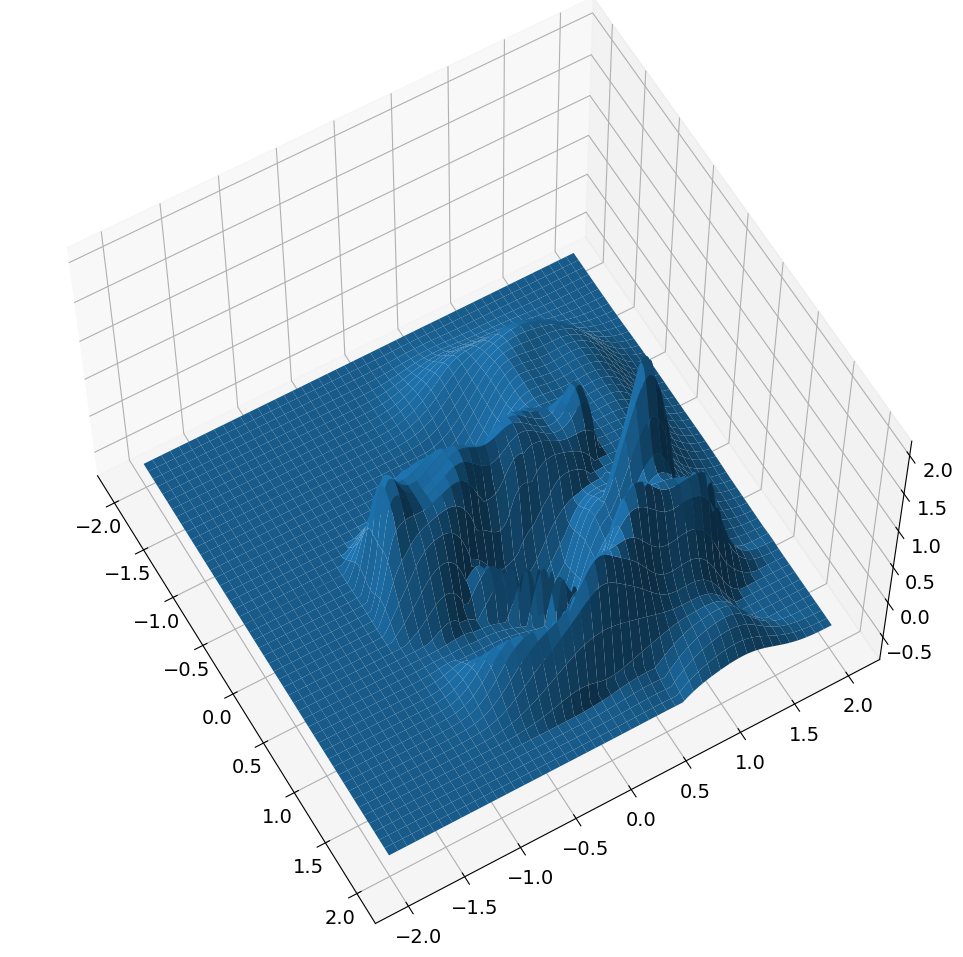

max h 2.124601838269041
target: [-1.21030681  1.32744132]
position is [ 0.71849275 -0.36014304]
h is 0.3582990823126069
start time is 150
norm grad 0.3473156534886015
norm grad 0.3933455867767572
norm grad 0.44273871628103395
norm grad 0.49468042845874793
norm grad 0.5483162422342963
norm grad 0.6027641759900261
norm grad 2.6828861142172347
norm grad 2.5476831202984616
norm grad 2.410365076242963
norm grad 2.273504963661276
norm grad 2.139325486437711
norm grad 2.0096488976147935
norm grad 1.8859351734619465
norm grad 1.769394226848164
norm grad 1.6610896912370807
norm grad 1.5619189786262735
norm grad 1.472508358093811
norm grad 1.3931627750669042
norm grad 1.3238367221040592
norm grad 1.2641910088324513
norm grad 1.2137010833823818
norm grad 1.1716708717340427
norm grad 1.1373011060423706
norm grad 1.1097281665458565
norm grad 1.0880097523313421
norm grad 1.0712061888420699
norm grad 1.0583697068295017
norm grad 1.0485266136569775
norm grad 1.0408053473096546
norm grad 1.034430555140

KeyboardInterrupt: 

In [23]:
##### ### Safe Exploration ###
##########################

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    prev_pos = a.pos  
    while np.linalg.norm(a.pos - prev_pos) <= tol:    
        target=a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
        while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
            target=a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
        print("target:", target) 
        a.goto(target, T=T, tend=tend, tol=tol, manual=True, DT=DT) 
        print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################
    # unsafe data:
    scan_safe, scan_unsafe = a.scan()
    samples  = a.sample(rx, grid=s_grid) 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples 
    # safe and buffer data:
    n_safe = scan_safe.shape[0]
    x_buffer, x_safe = a.make_buffer(scan_safe, int(nm * n_safe), p)
    u_buffer = np.array([hjb_controls(a, x, hjb_grid, all_values[-1], verbose=False) for x in x_buffer])
    u_safe   = np.array([hjb_controls(a, x, hjb_grid, all_values[-1], verbose=False) for x in x_safe])
    C  = [] 
    # centers:
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)
    a.centers.append(C)
    plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                               (x_buffer, "blue"  , 'o'), 
                               (x_unsafe, "red"   , 'o'),
                               (C       , "white" , '2')])
    #####################
    ### Learn new CBF ###
    #####################
    theta=cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_unsafe, gamma_dyn, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)
    a.thetas.append(theta)
    a.rectify_c_and_theta()
    plot_cbf(a, np.array(a.centers), np.array(a.thetas), obstacles=obstacles)

In [ ]:
a.pos = np.array([0, 0])
a.t   = 0
tol   = 0.5
for i in range(30):
    prev_pos = a.pos  
    while np.linalg.norm(a.pos - prev_pos) <= 0.45:
        target=a.width*np.random.rand(2) + a.width*unsafe_margin/2 - a.width/2
        while hjoint(target, a.thetas, a.centers) > 0:
            target=a.width*np.random.rand(2) + a.width*unsafe_margin/2 - a.width/2
        print("target:", target) 
        a.goto(target, T=2, tend=10, tol=tol) 
        print("dx:", np.linalg.norm(a.pos - prev_pos))
 
    '''
    first=True
    while hjoint(a.pos, a.thetas, a.centers) >= 1 or first:
        a.goto(target, T=7, tend=150, tol=tol)
        first = False
    '''
        
    scan_safe, scan_unsafe = a.scan()
    samples  = a.sample(rx, grid=s_grid) 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples 
    n_safe = scan_safe.shape[0]
    
    x_buffer, x_safe = a.make_buffer(scan_safe, int(n_mult * n_safe), prc) 
    u_buffer = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_buffer])
    u_safe   = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_safe])
    
    C  = []
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)
    a.centers.append(C)
    plot_data(grid, obs_dict, [(x_unsafe, "red"),
                               (C       , "green"),
                               (x_buffer, "blue"),
                               (x_safe  , "cyan")])

    theta = cvx_train_cbf(C, x_safe, u_safe, x_unsafe, x_buffer, u_buffer, params)
    print("vvvvvvvv this cbf vvvvvvvv")
    plot_cbf(a.width, [theta], [C], s=s)
    print("^^^^^^^^ this cbf ^^^^^^^^")
    a.thetas.append(theta)
    plot_cbf(a.width, a.thetas, a.centers, s=s)